Import Libraries:

In [47]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os
import time
import dask.array as da
import dask.dataframe as dd
import dask
from glob import glob
import shutil
from dask import delayed

Load all images and check that their third dimensions are all 3 (for 3 color channels):

In [53]:
def get_all_images():
    cwd = os.getcwd()
    image_dir = os.path.join(cwd,'flowers')
    all_images = []
    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir,image_file)
        if os.path.isfile(image_path):
            all_images.append(image_path)
    return all_images

In [54]:
all_images = get_all_images()

For Loop Method:

In [55]:
def invert_with_for_loops(img_list,output_folder):
    output_dir = os.path.join(os.getcwd(),output_folder)
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.mkdir(output_dir)
    for img_path in img_list:
        output_path = os.path.join(output_dir,os.path.basename(img_path))
        original_bgr = cv2.imread(img_path)
        new_bgr = np.empty(original_bgr.shape)
        for i in range(original_bgr.shape[0]):
            for j in range(original_bgr.shape[1]):
                for k in range(original_bgr.shape[2]):
                    new_bgr[i,j,k] = 255 - original_bgr[i, j, k]
        cv2.imwrite(output_path, new_bgr)


In [56]:
start_time = time.time()
invert_with_for_loops(['./cropped/bougainvillea_00002.jpg'],'for_loop_test')
end_time = time.time()
duration = end_time - start_time
print(duration)

0.22959685325622559


Vectorized Method:

In [57]:
def invert_vectorized(img_list,output_folder):
    output_dir = os.path.join(os.getcwd(),output_folder)
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.mkdir(output_dir)
    for img_path in img_list:
        output_path = os.path.join(output_dir,os.path.basename(img_path))
        original_bgr = cv2.imread(img_path)
        new_bgr = 255 - original_bgr
        cv2.imwrite(output_path, new_bgr)

In [58]:
start_time = time.time()
invert_vectorized(['./cropped/bougainvillea_00002.jpg'],'vectorized_test')
end_time = time.time()
duration = end_time - start_time
print(duration)

0.0007843971252441406


Using Dask (Vectorized and Multithreaded):

In [59]:
@dask.delayed()
def invert_one_image_with_dask(img_path,output_dir):
    original_bgr = cv2.imread(img_path)
    output_path = os.path.join(output_dir,os.path.basename(img_path))
    inverted = 255-original_bgr
    cv2.imwrite(output_path, inverted)

In [60]:
def invert_with_dask(img_list,output_folder):
    output_dir = os.path.join(os.getcwd(),output_folder)
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.mkdir(output_dir)

    lazy_images = [delayed(invert_one_image_with_dask)(img_path,output_dir) for img_path in img_list]
    res = dask.compute(lazy_images)[0]

In [64]:
start_time = time.time()
invert_with_dask(['./cropped/bougainvillea_00002.jpg'],'dask_test')
end_time = time.time()
duration = end_time - start_time
print(duration)

0.009548664093017578


Time Tests For 3 Methods Across Various Qtys of Files:

In [66]:
time_tests = {}
file_qtys = [1,5,10,20,50,100,150,200,250,300,350,400,450,500,550,600,650,700,733]
for qty in file_qtys:
    print(qty)
    time_tests[qty] = {}

    img_list = all_images[0:qty]

    #for loop method:
    for_loop_start_time = time.time()
    invert_with_for_loops(img_list,'for_loop_'+str(qty))
    for_loop_end_time = time.time()
    for_loop_duration = for_loop_end_time - for_loop_start_time

    #vectorized method:
    vectorized_start_time = time.time()
    invert_vectorized(img_list,'vectorized_'+str(qty))
    vectorized_end_time = time.time()
    vectorized_duration = vectorized_end_time - vectorized_start_time

    #vectorized & multithreaded method:
    dask_start_time = time.time()
    invert_with_dask(img_list,'dask_'+str(qty))
    dask_end_time = time.time()
    dask_duration = dask_end_time - dask_start_time

    time_tests[qty]['for_loop'] = for_loop_duration
    time_tests[qty]['vectorized'] = vectorized_duration
    time_tests[qty]['dask'] = dask_duration


1
5
10
20
50
100
150
200
250
300
350
400
450
500
550
600
650
700
733


In [67]:
print(time_tests)

{1: {'for_loop': 1.9479639530181885, 'vectorized': 0.023685216903686523, 'dask': 0.01559901237487793}, 5: {'for_loop': 15.02751111984253, 'vectorized': 0.1425492763519287, 'dask': 0.03139019012451172}, 10: {'for_loop': 22.213217973709106, 'vectorized': 0.22945690155029297, 'dask': 0.057466983795166016}, 20: {'for_loop': 50.180004835128784, 'vectorized': 0.6035370826721191, 'dask': 0.2470569610595703}, 50: {'for_loop': 114.11343312263489, 'vectorized': 1.5978353023529053, 'dask': 0.4673118591308594}, 100: {'for_loop': 236.43164587020874, 'vectorized': 3.1978421211242676, 'dask': 0.808140754699707}, 150: {'for_loop': 554.2769193649292, 'vectorized': 6.289849281311035, 'dask': 1.5931735038757324}, 200: {'for_loop': 674.2497010231018, 'vectorized': 9.031426191329956, 'dask': 1.9868927001953125}, 250: {'for_loop': 1066.675733089447, 'vectorized': 11.533979654312134, 'dask': 2.165926933288574}, 300: {'for_loop': 1398.0778994560242, 'vectorized': 17.94271755218506, 'dask': 4.2214579582214355}

In [68]:
df = pd.DataFrame.from_dict(time_tests,orient='index')
print(df)

        for_loop  vectorized       dask
1       1.947964    0.023685   0.015599
5      15.027511    0.142549   0.031390
10     22.213218    0.229457   0.057467
20     50.180005    0.603537   0.247057
50    114.113433    1.597835   0.467312
100   236.431646    3.197842   0.808141
150   554.276919    6.289849   1.593174
200   674.249701    9.031426   1.986893
250  1066.675733   11.533980   2.165927
300  1398.077899   17.942718   4.221458
350  1092.358360   11.502324   2.746192
400  1132.510972   13.396102   3.319690
450  1236.813172   17.383927  16.912667
500  1355.528615   19.917259   4.349099
550  1461.731395   21.656435   4.807515
600  1770.100165   26.017122   5.296411
650  2086.268233   31.383209   5.950808
700  3369.284475   26.384115   6.732904
733  2046.428134   27.482817   6.965683


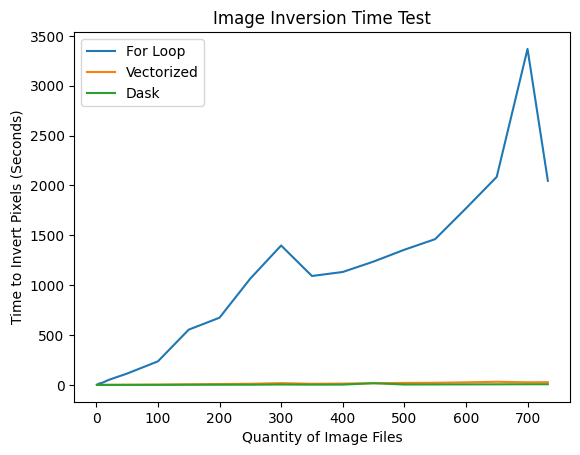

In [69]:
plt.plot(df['for_loop'],label='For Loop')
plt.plot(df['vectorized'],label='Vectorized')
plt.plot(df['dask'],label='Dask')
plt.xlabel('Quantity of Image Files')
plt.ylabel('Time to Invert Pixels (Seconds)')
plt.title('Image Inversion Time Test')
plt.legend()
plt.show()

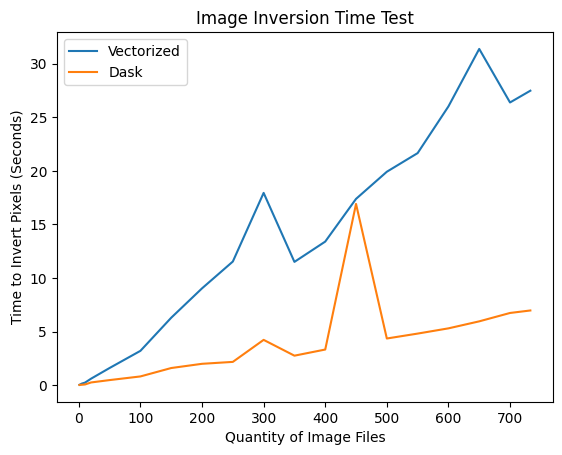

In [70]:
# plt.plot(df['for_loop'],label='For Loop')
plt.plot(df['vectorized'],label='Vectorized')
plt.plot(df['dask'],label='Dask')
plt.xlabel('Quantity of Image Files')
plt.ylabel('Time to Invert Pixels (Seconds)')
plt.title('Image Inversion Time Test')
plt.legend()
plt.show()